
Custom Workloads with Dask Delayed
==================================

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">

*Because not all problems are dataframes*

This notebook shows using [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to parallelize generic Python code.  

Dask.delayed is a simple and powerful way to parallelize existing code.  It allows users to delay function calls into a task graph with dependencies.  Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed.  If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

## Create simple functions

These functions do simple operations like add two numbers together, but they sleep for a random amount of time to simulate real work.

In [1]:

from distributed import Client
client=Client('tcp://10.9.0.28:8786')

/tools/Conda/envs/dask312/lib/python3.12/site-packages/distributed/client.py:1612: VersionMismatchWarning: Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | Client         | Scheduler      | Workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 3.1.0          | 3.0.0          | 3.0.0          |
| pandas      | 2.2.3          | 2.2.2          | 2.2.2          |
| python      | 3.12.0.final.0 | 3.12.7.final.0 | 3.12.7.final.0 |
| toolz       | 1.0.0          | 0.12.0         | 0.12.0         |
+-------------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [2]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [3]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [4]:
z.compute()

array([0.99755147, 0.99425683, 1.00894412, ..., 0.99639472, 0.99544744,
       0.99967661])

In [5]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1
    
def add(x, y):
    time.sleep(random.random())
    return x + y 

We can run them like normal Python functions below

In [6]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 0 ns, sys: 4.55 ms, total: 4.55 ms
Wall time: 1.78 s


3

These ran one after the other, in sequence.  Note though that the first two lines `inc(1)` and `dec(2)` don't depend on each other, we *could* have called them in parallel had we been clever.

## Annotate functions with Dask Delayed to make them lazy

We can call `dask.delayed` on our funtions to make them lazy.  Rather than compute their results immediately, they record what we want to compute as a task into a graph that we'll run later on parallel hardware.

In [7]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Calling these lazy functions is now almost free.  We're just constructing a graph

In [8]:
x = inc(1)
y = dec(2)
z = add(x, y)
z

Delayed('add-4e8aec0c-c21c-4df2-9184-eb112d084b70')

## Visualize computation
You will need graphviz installed for this to work

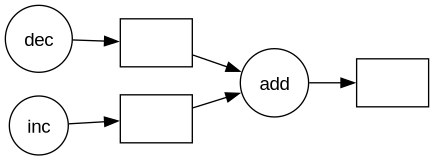

In [9]:
z.visualize(rankdir='LR')

## Run in parallel

Call `.compute()` when you want your result as a normal Python object

In [10]:
%%time
z.compute()

CPU times: user 7.92 ms, sys: 0 ns, total: 7.92 ms
Wall time: 1.03 s


3

## Parallelize Normal Python code

Now we use Dask in normal for-loopy Python code.  This generates graphs instead of doing computations directly, but still looks like the code we had before.  Dask is a convenient way to add parallelism to existing workflows.

In [11]:
zs = []

In [12]:
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

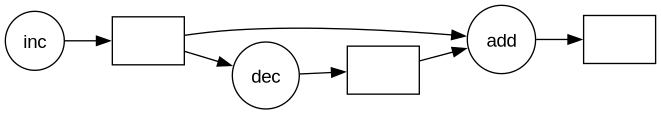

In [13]:
zs[0].visualize(rankdir='LR')

In [14]:
zs = dask.compute(*zs)

## Custom computation: Tree summation

As an example of a non-trivial algorithm, consider the classic tree reduction.  We accomplish this with a nested for loop and a bit of normal Python logic.

```
finish           total             single output
    ^          /        \
    |        c1          c2        neighbors merge
    |       /  \        /  \
    |     b1    b2    b3    b4     neighbors merge
    ^    / \   / \   / \   / \
start   a1 a2 a3 a4 a5 a6 a7 a8    many inputs
```

In [15]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

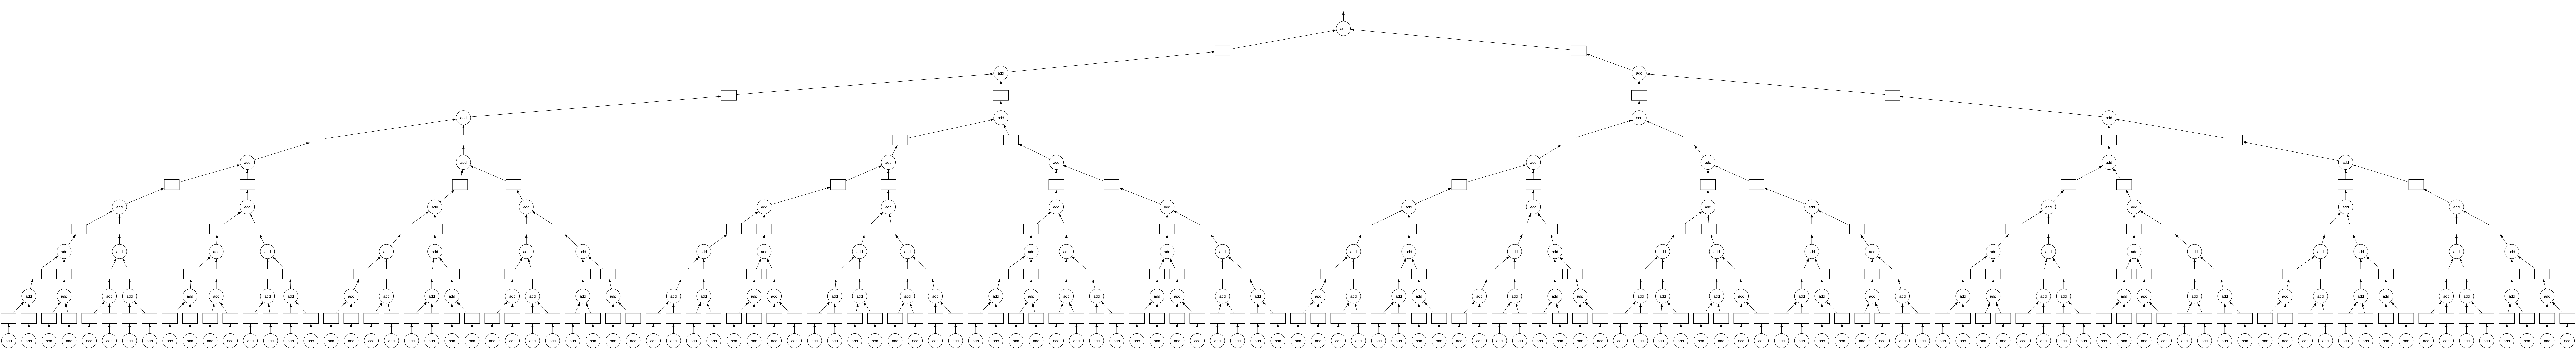

In [16]:
L[0].visualize()

In [17]:
dask.compute(*L)

(65536,)

## Further Reading

For a more in-depth introdution to delayed and lazy operation in Dask, see the [dask tutorial](https://tutorial.dask.org/03_dask.delayed.html)